# CHAPTER 5.5

### Creating an inverse image search index with deep learning

Whole point of an autoencoder is to learn an encoding or a low-dimensional representation of a set of images, they make for great feature extractors. Furthermore, we can use them as the perfect building blocks of image search indices, as we'll discover in this notebook

In [1]:
import cv2
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import *

In [2]:
(X_train, _), (X_test, _) = fashion_mnist.load_data()

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

As before, we don't need labels... We will train our model to reconstruct same images. but this time after training, we only need 'encoder' part for feature extraction. After feature extraction we will create a dataset and search new image with its features in this dataset and choose the similar images according to our loss function.
Because of that reason the most important point is to give encoder part a name to use later.

In [3]:
def build_autoencoder(input_shape=(28, 28, 1),
                      encoding_size=32,
                      alpha=0.2):
    inputs = Input(shape=input_shape)
    encoder = Conv2D(filters=32,
                     kernel_size=(3, 3),
                     strides=2,
                     padding='same')(inputs)
    encoder = LeakyReLU(alpha=alpha)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Conv2D(filters=64,
                     kernel_size=(3, 3),
                     strides=2,
                     padding='same')(encoder)
    encoder = LeakyReLU(alpha=alpha)(encoder)
    encoder = BatchNormalization()(encoder)

    encoder_output_shape = encoder.shape
    encoder = Flatten()(encoder)
    encoder_output = Dense(units=encoding_size,
                           name='encoder_output')(encoder)
    # Build decoder
    target_shape = tuple(encoder_output_shape[1:])
    decoder = Dense(np.prod(target_shape))(encoder_output)
    decoder = Reshape(target_shape)(decoder)

    decoder = Conv2DTranspose(filters=64,
                              kernel_size=(3, 3),
                              strides=2,
                              padding='same')(decoder)
    decoder = LeakyReLU(alpha=alpha)(decoder)
    decoder = BatchNormalization()(decoder)

    decoder = Conv2DTranspose(filters=32,
                              kernel_size=(3, 3),
                              strides=2,
                              padding='same')(decoder)
    decoder = LeakyReLU(alpha=alpha)(decoder)
    decoder = BatchNormalization()(decoder)

    decoder = Conv2DTranspose(filters=1,
                              kernel_size=(3, 3),
                              padding='same')(decoder)
    outputs = Activation(activation='sigmoid',
                         name='decoder_output')(decoder)
    autoencoder_model = Model(inputs, outputs)

    return autoencoder_model

In [4]:
autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')

In [5]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                             

In [6]:
EPOCHS = 10
BATCH_SIZE = 512
autoencoder.fit(X_train, X_train,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/10
118/118 [==============================] - 17s 33ms/step - loss: 0.0386 - val_loss: 0.1293
Epoch 2/10
118/118 [==============================] - 3s 30ms/step - loss: 0.0160 - val_loss: 0.0997
Epoch 3/10
118/118 [==============================] - 3s 30ms/step - loss: 0.0129 - val_loss: 0.0666
Epoch 4/10
118/118 [==============================] - 3s 30ms/step - loss: 0.0117 - val_loss: 0.0370
Epoch 5/10
118/118 [==============================] - 3s 30ms/step - loss: 0.0108 - val_loss: 0.0167
Epoch 6/10
118/118 [==============================] - 4s 30ms/step - loss: 0.0103 - val_loss: 0.0118
Epoch 7/10
118/118 [==============================] - 4s 31ms/step - loss: 0.0097 - val_loss: 0.0101
Epoch 8/10
118/118 [==============================] - 4s 30ms/step - loss: 0.0094 - val_loss: 0.0097
Epoch 9/10
118/118 [==============================] - 4s 30ms/step - loss: 0.0090 - val_loss: 0.0093
Epoch 10/10
118/118 [==============================] - 4s 31ms/step - loss: 0.0089 - val_l

Need a feature extractor from our autoencoder's encoder part

In [7]:
fe_input = autoencoder.input
fe_output = autoencoder.get_layer('encoder_output').output
feature_extractor = Model(inputs=fe_input, outputs=fe_output)

In [8]:
feature_extractor.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                           

In [9]:
train_vectors = feature_extractor.predict(X_train)

In [10]:
train_vectors.shape

(60000, 32)

In [11]:
X_train = (X_train * 255.0).astype('uint8')
X_train = X_train.reshape((X_train.shape[0], 28, 28))
search_index = {
    'features': train_vectors,
    'images': X_train
}

In [12]:
test_vectors = feature_extractor.predict(X_test)

X_test = (X_test * 255.0).astype('uint8')
X_test = X_test.reshape((X_test.shape[0], 28, 28))


In [13]:
test_vectors.shape

(10000, 32)

In [14]:
sample_indices = np.random.randint(0, X_test.shape[0], 16)

In [15]:
sample_indices

array([7548, 2101, 7048, 9858, 8961, 8982, 7140, 8065, 8966, 9254, 5042,
       7156, 6620, 7493, 8159, 5505])

In [16]:
sample_images = X_test[sample_indices]
sample_queries = test_vectors[sample_indices]

In [18]:
sample_images.shape

(16, 28, 28)

In [19]:
sample_queries.shape

(16, 32)

In [20]:
def euclidean_dist(x, y):
    return np.linalg.norm(x - y)

In [21]:
def search(query_vector, search_index, max_results=16):
    vectors = search_index['features']
    results = []

    for i in range(len(vectors)):
        distance = euclidean_dist(query_vector, vectors[i])
        results.append((distance, search_index['images'][i]))

    results = sorted(results,
                     key=lambda p: p[0])[:max_results]
    return results

In [22]:
for i, (vector, image) in \
        enumerate(zip(sample_queries, sample_images)):
    results = search(vector, search_index)
    results = [r[1] for r in results]
    query_image = cv2.resize(image, (28 * 4, 28 * 4),
                             interpolation=cv2.INTER_AREA)

    results_mosaic = np.vstack([np.hstack(results[0:4]),
                                np.hstack(results[4:8]),
                                np.hstack(results[8:12]),
                                np.hstack(results[12:16])])
    result_image = np.hstack([query_image, results_mosaic])
    cv2.imwrite(f'{i}.jpg', result_image)

And it created 15 images , and here is a screenshot of 4 of them : 

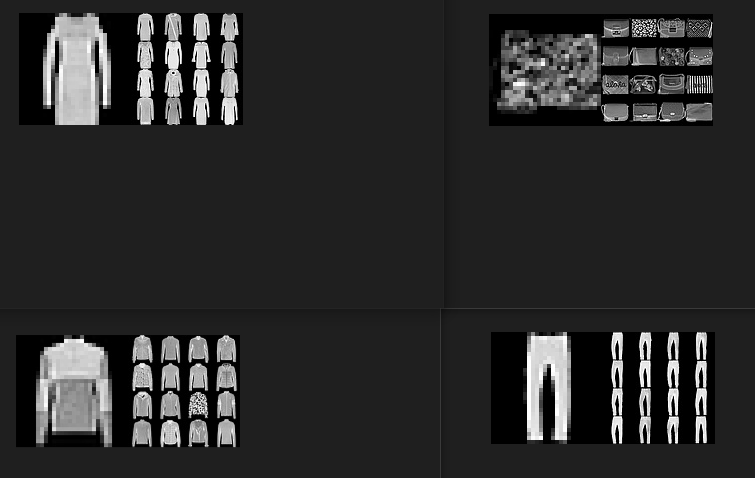

The most important aspect in our solution is to train an autoencoder that is good enough
to produce high-quality vectors, since they make or break the search engine.